There are 2 additional steps to use DeepCTR with sequence feature input.

1. Generate the paded and encoded sequence feature of sequence input feature(value 0 is for padding).
2. Generate config of sequence feature with VarLenSparseFeat

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names

In [2]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [3]:
data = pd.read_csv("./data/movielens_sample.txt")

In [4]:
data.head(3)

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,3299,235,4,968035345,Ed Wood (1994),Comedy|Drama,F,25,4,19119
1,3630,3256,3,966536874,Patriot Games (1992),Action|Thriller,M,18,4,77005
2,517,105,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,F,25,14,55408


In [5]:
sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]
target = ['rating']

In [6]:
# Label Encoding for sparse features,and process sequence features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [7]:
# preprocess the sequence feature
key2index = {}
genres_list = list(map(split, data['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )

In [68]:
# Count #unique features for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4)
                            for feat in sparse_features]

use_weighted_sequence = False
if use_weighted_sequence:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean',
                                                weight_name='genres_weight')]  # Notice : value 0 is for padding for sequence input feature
else:
    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean',
                                                weight_name=None)]  # Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [69]:
feature_names

['movie_id', 'user_id', 'gender', 'age', 'occupation', 'zip', 'genres']

In [70]:
if use_weighted_sequence:
    feature_names.remove('genres_weight')

In [71]:
# Generate input data for model
model_input = {name: data[name] for name in feature_names}
model_input["genres"] = genres_list
# model_input["genres_weight"] = np.random.randn(data.shape[0], max_len, 1)

In [72]:
from tensorflow.python.keras.optimizers import adam_v2

# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile(adam_v2.Adam(1e-3), "mse", metrics=['mse'], )

history = model.fit(model_input, data[target].values,
                    batch_size=256, epochs=60, verbose=2, validation_split=0.2)

Epoch 1/60
1/1 - 3s - loss: 14.3000 - mse: 14.3000 - val_loss: 13.3821 - val_mse: 13.3821
Epoch 2/60
1/1 - 0s - loss: 14.1590 - mse: 14.1590 - val_loss: 13.2429 - val_mse: 13.2429
Epoch 3/60
1/1 - 0s - loss: 13.9945 - mse: 13.9945 - val_loss: 13.0915 - val_mse: 13.0915
Epoch 4/60
1/1 - 0s - loss: 13.8165 - mse: 13.8165 - val_loss: 12.9236 - val_mse: 12.9236
Epoch 5/60
1/1 - 0s - loss: 13.6211 - mse: 13.6211 - val_loss: 12.7367 - val_mse: 12.7367
Epoch 6/60
1/1 - 0s - loss: 13.4050 - mse: 13.4050 - val_loss: 12.5296 - val_mse: 12.5296
Epoch 7/60
1/1 - 0s - loss: 13.1667 - mse: 13.1667 - val_loss: 12.3009 - val_mse: 12.3009
Epoch 8/60
1/1 - 0s - loss: 12.9044 - mse: 12.9044 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 9/60
1/1 - 0s - loss: 12.6154 - mse: 12.6154 - val_loss: 11.7696 - val_mse: 11.7696
Epoch 10/60
1/1 - 0s - loss: 12.2963 - mse: 12.2963 - val_loss: 11.4618 - val_mse: 11.4618
Epoch 11/60
1/1 - 0s - loss: 11.9439 - mse: 11.9439 - val_loss: 11.1242 - val_mse: 11.1242
Epoch 12

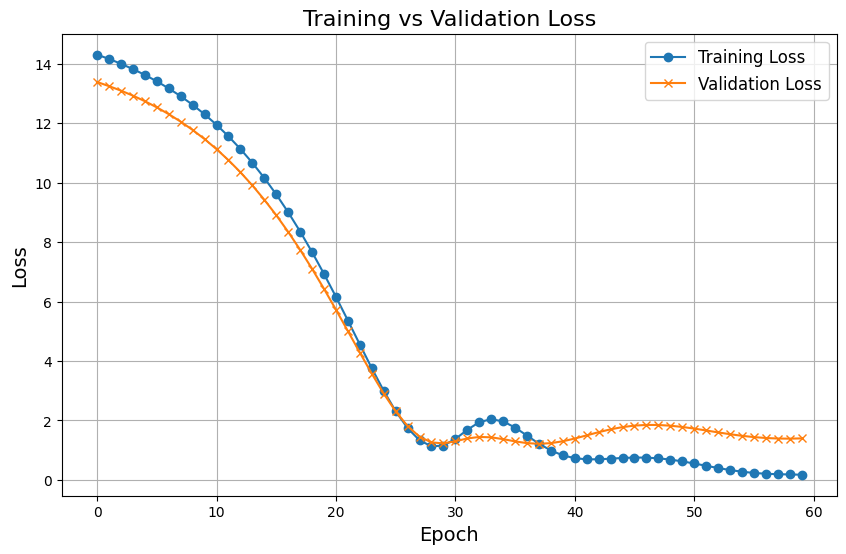

In [73]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### Inference

In [89]:
import numpy as np

model_input = {'movie_id': np.array([100]),
               'user_id': np.array([20]),
               'gender': np.array([1]),
               'age': np.array([3]),
               'occupation': np.array([15]),
               'zip': np.array([100]),
               'genres': np.array([[1, 3, 0, 0, 0]])
}

In [90]:
model.predict(model_input)

array([[4.051315]], dtype=float32)